In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
39479,NaN,NaN,International,2020-08-23,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39480,NaN,NaN,International,2020-08-24,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39481,NaN,NaN,International,2020-08-25,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


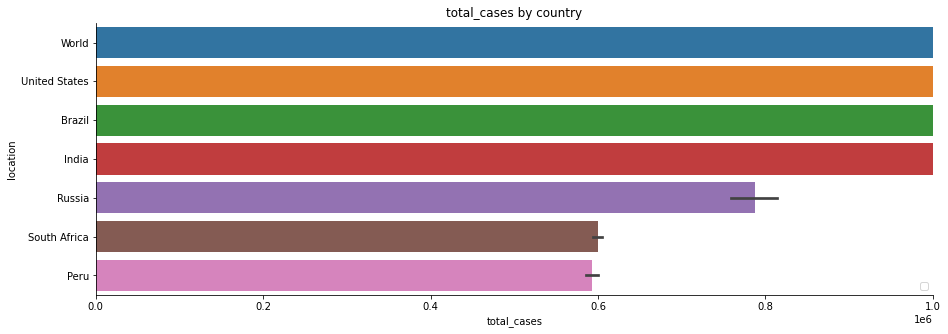

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


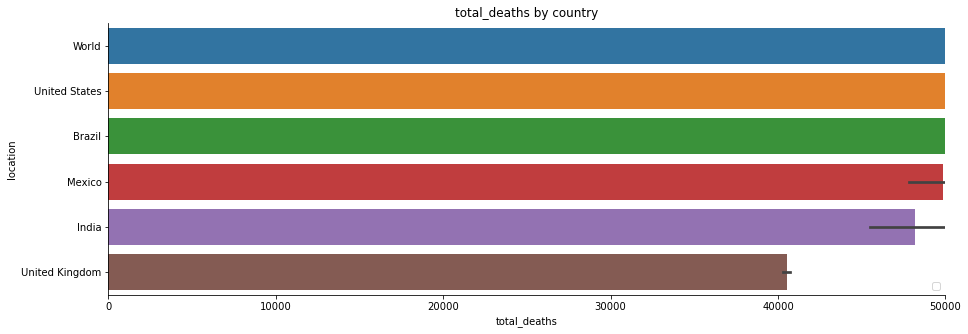

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


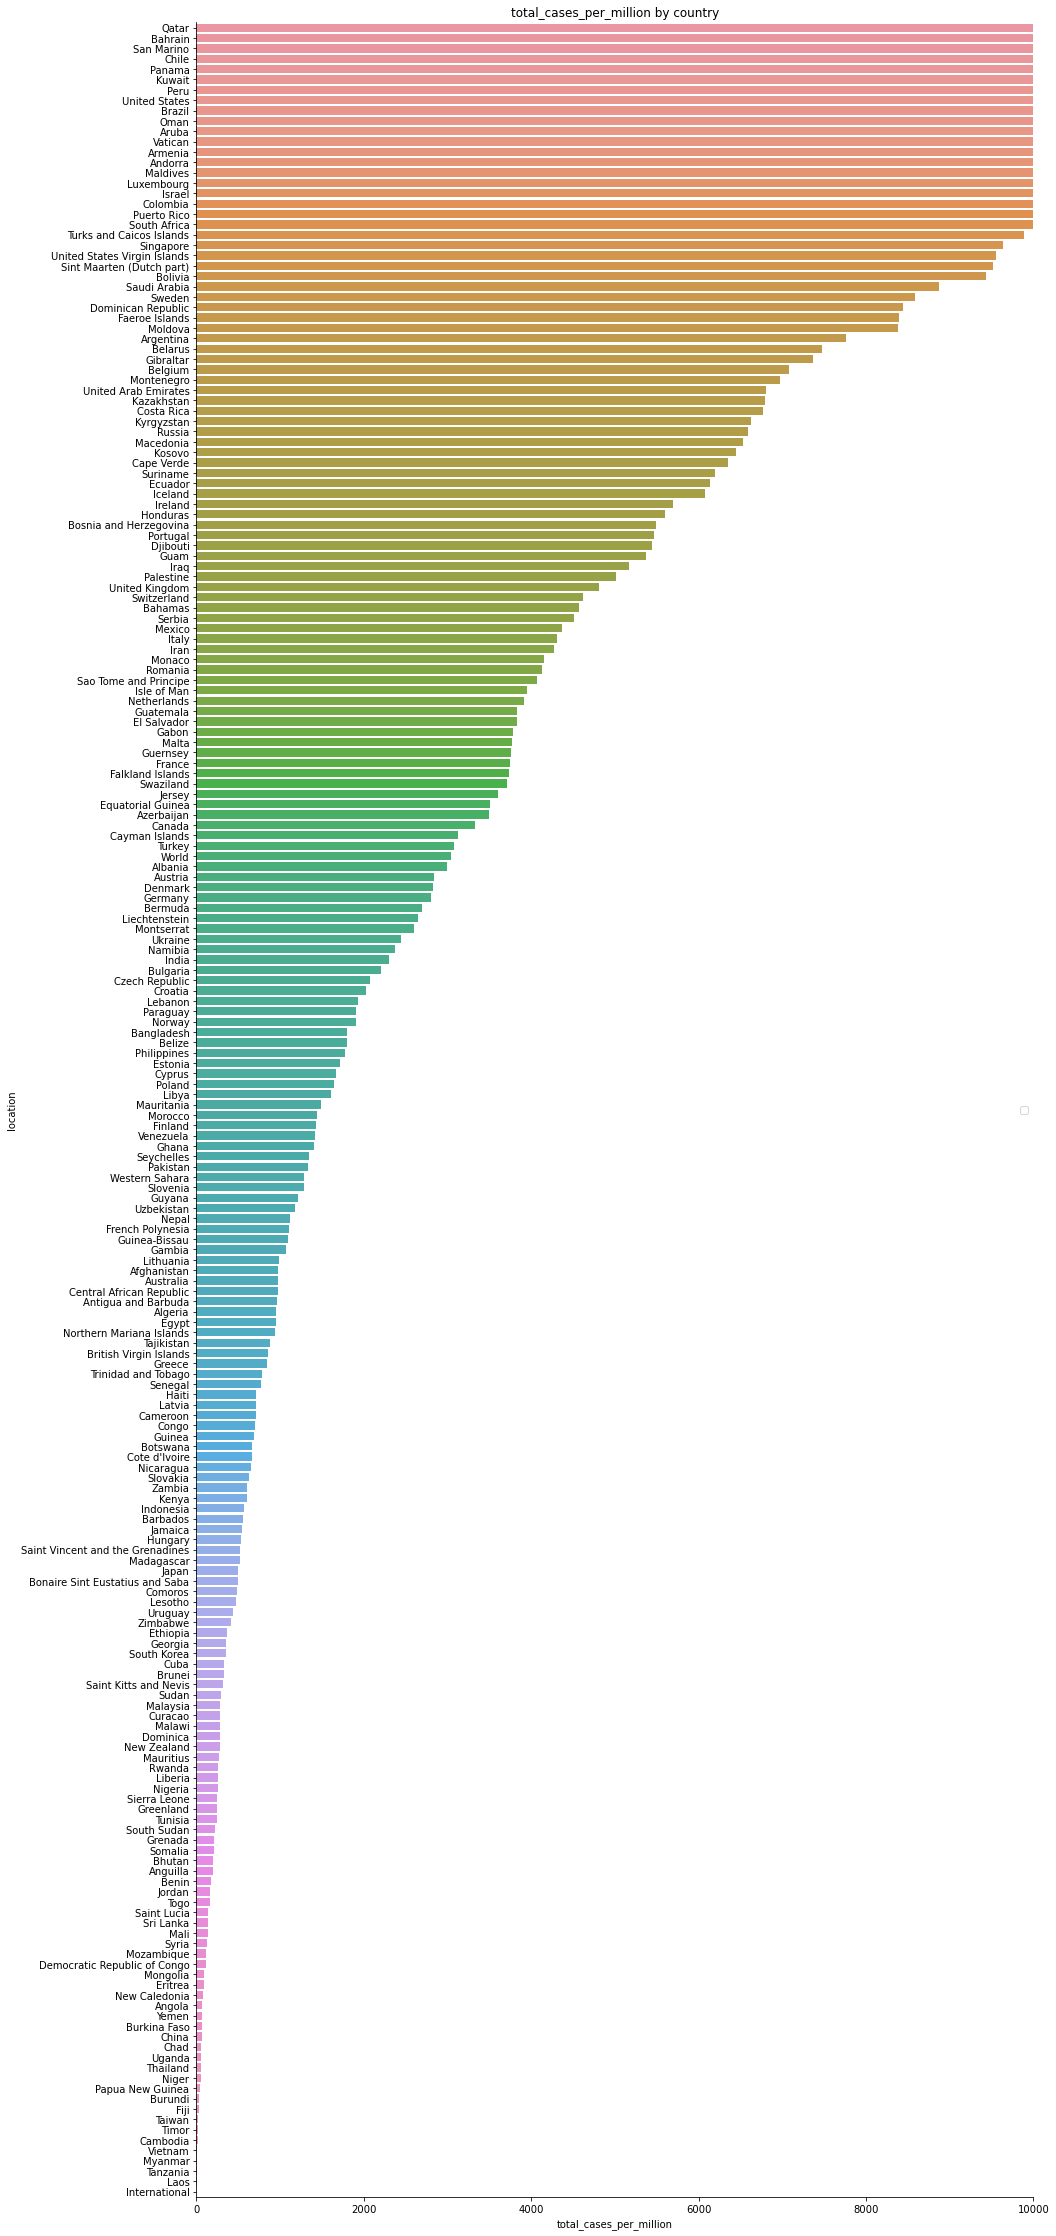

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


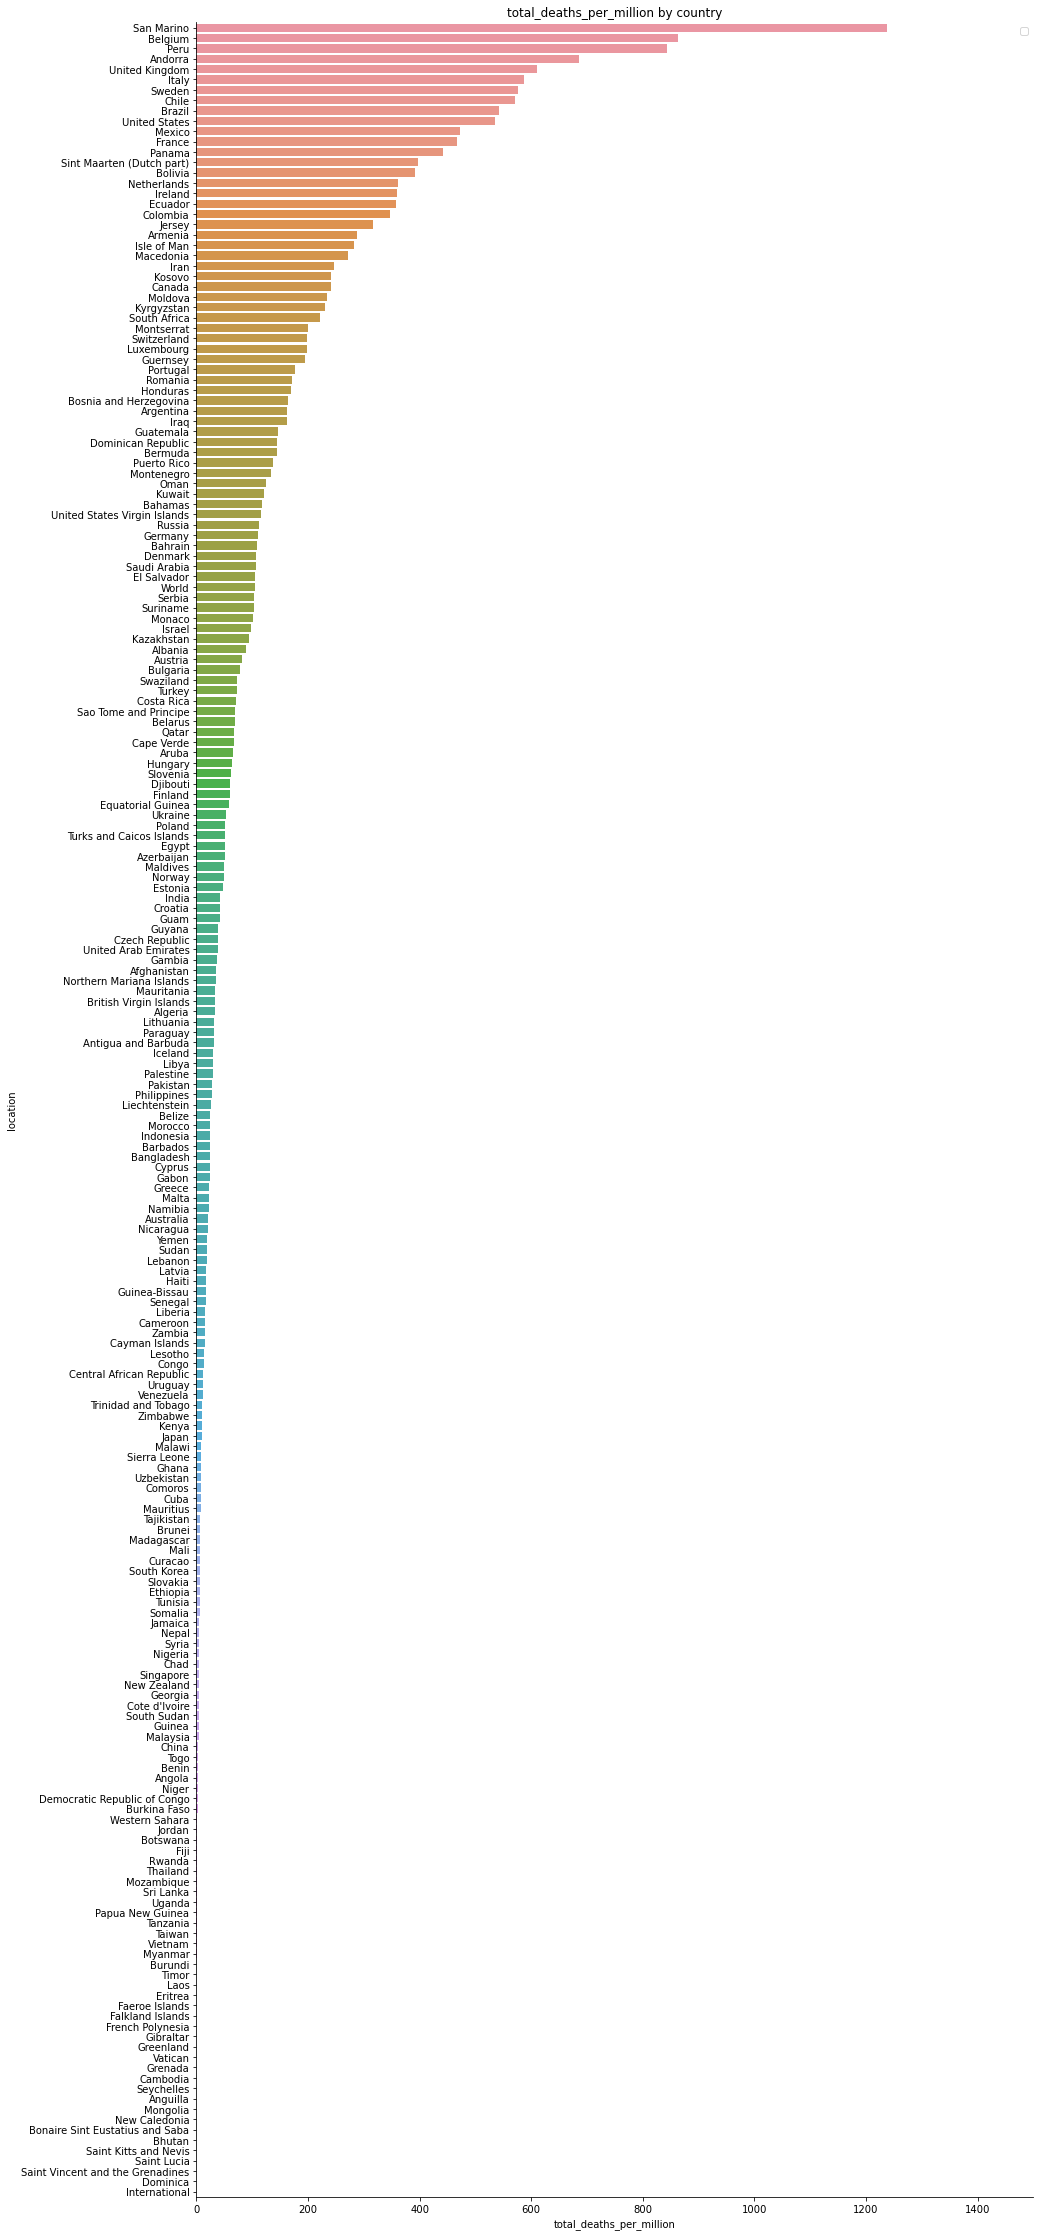

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

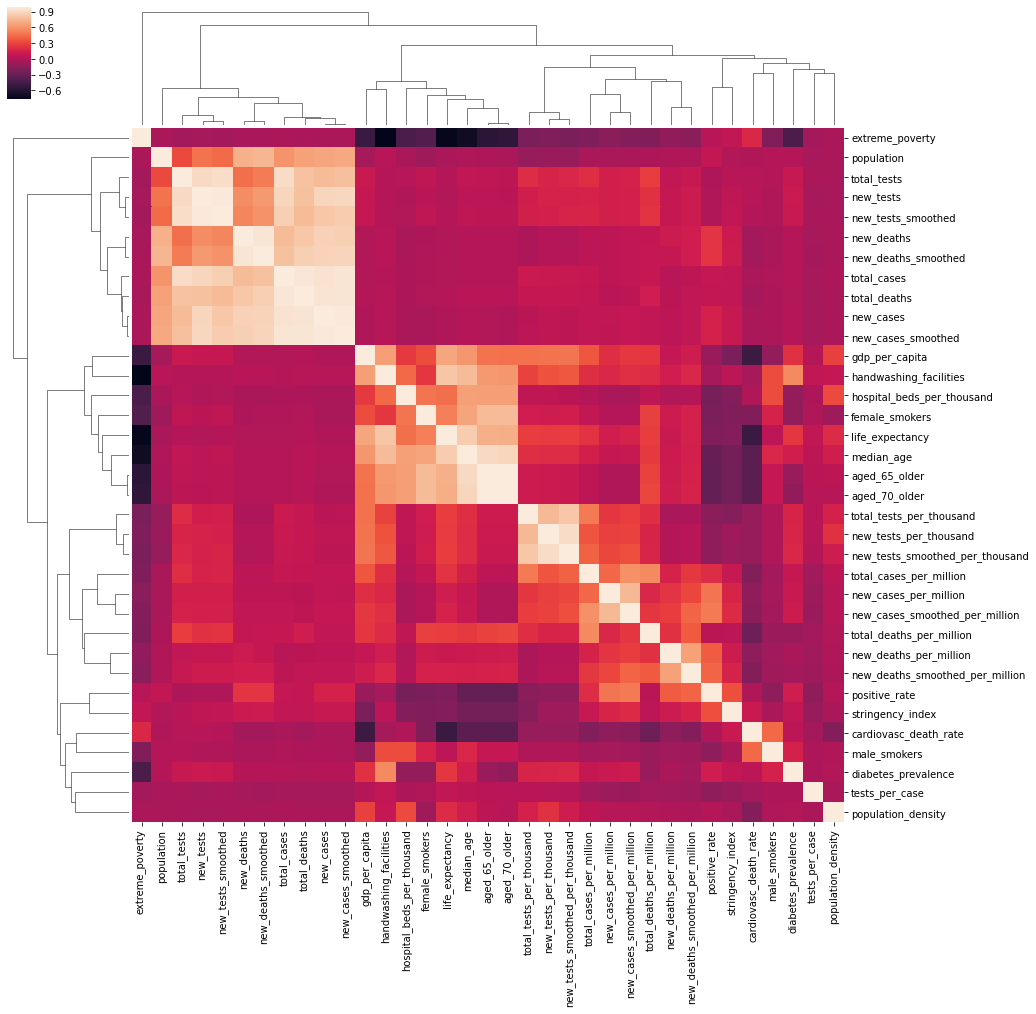

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995063868930564 (+/- 0.0003353666746463402)
Coef :  [1.03957634e+00 8.84495862e-05 9.49479660e-05]
3 Last_days :  [[23236699 23461109 23673902]]
Today :  23673902
Prediction + :  562321
Tomorow :  24236223
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996237232346137 (+/- 2.919452041776182e-05)
Coef :  [-0.01227459  0.49276087  0.52957935]
3 Last_days :  [[805692 809457 813944]]
Today :  813944
Prediction + :  8457
Tomorow :  822401
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9722763354362806 (+/- 0.031796945382150235)
Coef :  [-0.67766497  0.73694297  0.94216579]
3 Last_days :  [[238002 242899 244854]]
Today :  244854
Prediction + :  3831
Tomorow :  248685
                                     
--------- Total Death -----------------
                                     
R^2: 0.3856262681341578 (+/- 0.8562518641951407)
Coef :  [-0.75377906  0.7885463   0.96430586]
3 Last_days :  [[30512 30513 30528]]
Today :  30528
Prediction + :  23
Tomorow :  30551
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.858785953157604 (+/- 0.10737957780491142)
Coef :  [-0.32337788 -0.02213396  1.33978174]
3 Last_days :  [[89654 89695 89718]]
Today :  89718
Prediction + :  35
Tomorow :  89753
                                     
--------- Total Death -----------------
                                     
R^2: -450.03125145356466 (+/- 637.6644467481906)
Coef :  [-0.07683431  0.01242409  1.05637603]
3 Last_days :  [[4711 4711 4711]]
Today :  4711
Prediction + :  6
Tomorow :  4717
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7558245715740596 (+/- 0.3441547565063738)
Coef :  [-0.83232977  0.90238371  0.92919184]
3 Last_days :  [[258136 259345 260298]]
Today :  260298
Prediction + :  1119
Tomorow :  261417
                                     
--------- Total Death -----------------
                                     
R^2: 0.8999847425988365 (+/- 0.11460893442354096)
Coef :  [-0.83187305  0.90120185  0.92982823]
3 Last_days :  [[35430 35437 35441]]
Today :  35441
Prediction + :  28
Tomorow :  35469
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6523982702343128 (+/- 0.4797732762761933)
Coef :  [-0.65061455  0.54589217  1.10616644]
3 Last_days :  [[386054 386054 405436]]
Today :  405436
Prediction + :  2875
Tomorow :  408311
                                     
--------- Total Death -----------------
                                     
R^2: 0.16187632902127602 (+/- 0.9918662922999963)
Coef :  [-0.72132412  0.61709566  1.1032238 ]
3 Last_days :  [[28838 28838 28872]]
Today :  28872
Prediction + :  12
Tomorow :  28884
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9971086556717895 (+/- 0.0037399965275284604)
Coef :  [0.07604928 0.46353855 0.47794407]
3 Last_days :  [[5668105 5702611 5740909]]
Today :  5740909
Prediction + :  89715
Tomorow :  5830624
                                     
--------- Total Death -----------------
                                     
R^2: 0.46809276750763856 (+/- 0.7507353009704038)
Coef :  [-0.58378632  0.74871705  0.83739218]
3 Last_days :  [[176362 176806 177279]]
Today :  177279
Prediction + :  880
Tomorow :  178159
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9828389758459347 (+/- 0.023372692243829783)
Coef :  [-0.76199376  0.86780939  0.894279  ]
3 Last_days :  [[324601 325642 326614]]
Today :  326614
Prediction + :  1189
Tomorow :  327803
                                     
--------- Total Death -----------------
                                     
R^2: 0.42173200061379973 (+/- 0.7869776437216494)
Coef :  [-0.77471085  0.83242147  0.94174729]
3 Last_days :  [[41423 41429 41433]]
Today :  41433
Prediction + :  42
Tomorow :  41475
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9806454336900762 (+/- 0.024687740139632222)
Coef :  [-0.80458902  0.86107201  0.94312241]
3 Last_days :  [[232864 233575 234853]]
Today :  234853
Prediction + :  709
Tomorow :  235562
                                     
--------- Total Death -----------------
                                     
R^2: 0.4253455446007612 (+/- 0.7998299962014551)
Coef :  [-0.79425864  0.84185442  0.95176815]
3 Last_days :  [[9269 9272 9277]]
Today :  9277
Prediction + :  9
Tomorow :  9286
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.03347393662376611 (+/- 1.365915375091626)
Coef :  [0.20328713 0.40685009 0.40212081]
3 Last_days :  [[356792 358905 358905]]
Today :  358905
Prediction + :  5260
Tomorow :  364165
                                     
--------- Total Death -----------------
                                     
R^2: 0.8831599436146679 (+/- 0.1647332778357642)
Coef :  [-0.00247709  0.51449349  0.50110782]
3 Last_days :  [[20502 20643 20643]]
Today :  20643
Prediction + :  318
Tomorow :  20961
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9982629662770656 (+/- 0.0021999060770750006)
Coef :  [-0.74848588  0.8537248   0.89200353]
3 Last_days :  [[257032 258249 259692]]
Today :  259692
Prediction + :  1042
Tomorow :  260734
                                     
--------- Total Death -----------------
                                     
R^2: 0.999192979904474 (+/- 0.0008443209979278946)
Coef :  [-0.81623856  0.89725621  0.91595464]
3 Last_days :  [[6102 6121 6139]]
Today :  6139
Prediction + :  17
Tomorow :  6156
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4629034253276885 (+/- 0.7554270499432596)
Coef :  [-0.1736801   0.49456825  0.69564692]
3 Last_days :  [[3582362 3605783 3622861]]
Today :  3622861
Prediction + :  64021
Tomorow :  3686882
                                     
--------- Total Death -----------------
                                     
R^2: 0.5014376962390338 (+/- 0.6973042913266568)
Coef :  [-0.15594702  0.53148284  0.63720629]
3 Last_days :  [[114250 114744 115309]]
Today :  115309
Prediction + :  1568
Tomorow :  116877
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(23673902, 813944, 24236223, 822401),
 (244854, 30528, 248685, 30551),
 (260298, 35441, 261417, 35469),
 (405436, 28872, 408311, 28884),
 (5740909, 177279, 5830624, 178159),
 (89718, 4711, 89753, 4717),
 (326614, 41433, 327803, 41475),
 (234853, 9277, 235562, 9286),
 (358905, 20643, 364165, 20961),
 (259692, 6139, 260734, 6156),
 (3622861, 115309, 3686882, 116877)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-25,France,248685.0,0.0,30551.0,0.0,0.0,0.0
0,2020-08-25,China,89753.0,0.0,4717.0,0.0,0.0,0.0
0,2020-08-25,Italy,261417.0,0.0,35469.0,0.0,0.0,0.0
0,2020-08-25,Spain,408311.0,0.0,28884.0,0.0,0.0,0.0
0,2020-08-25,United States,5830624.0,0.0,178159.0,0.0,0.0,0.0
0,2020-08-25,World,24236223.0,0.0,822401.0,0.0,0.0,0.0
0,2020-08-25,United Kingdom,327803.0,0.0,41475.0,0.0,0.0,0.0
0,2020-08-25,Germany,235562.0,0.0,9286.0,0.0,0.0,0.0
0,2020-08-25,Iran,364165.0,0.0,20961.0,0.0,0.0,0.0
0,2020-08-25,Turkey,260734.0,0.0,6156.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")